In [4]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")

import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from importlib import reload    

from src.utils.config import CONFIG

from src.utils.data_loader import create_loaders
from notebooks.yasser.custom_model import Custom_model     
from src.utils.train_model_sr import train_model_sr
import json


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = 70 #CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = 0.0001 #CONFIG["training"]["lr"]
weight_decay    = 0
num_epochs      = 70 #CONFIG["training"]["epochs"]
step_size       = 30 #CONFIG["training"]["scheduler_step_size"]
gamma           = 0.5 #CONFIG["training"]["scheduler_gamma"]


# LOAD DATA 

train_loader, val_loader, test_loader = create_loaders(
    root=data_root,
    batch_size=batch_size,
    num_workers=num_workers,
    use_augmentation=use_aug
)

model_large = Custom_model(n_HF_blocks=12,n_MS_blocks=4,n_LF_blocks=20).to(device)


criterion = nn.L1Loss()
optimizer = optim.Adam(model_large.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.5)

best_model_path = CONFIG["model"]["best_custom_large_path"]
last_model_path = CONFIG["model"]["last_custom_large_path"]
history_path = CONFIG["history"]["custom_large_history_path"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device : cuda

 DATA LOADED:
  Train: 152352 samples
  Val:   19044 samples
  Test:  19044 samples


Loading LAST checkpoint: src/models/checkpoints/custom_large/last_custom_large.pth
 Fine-tuning epoch 100 | Best PSNR = 28.22
 Loading training history...


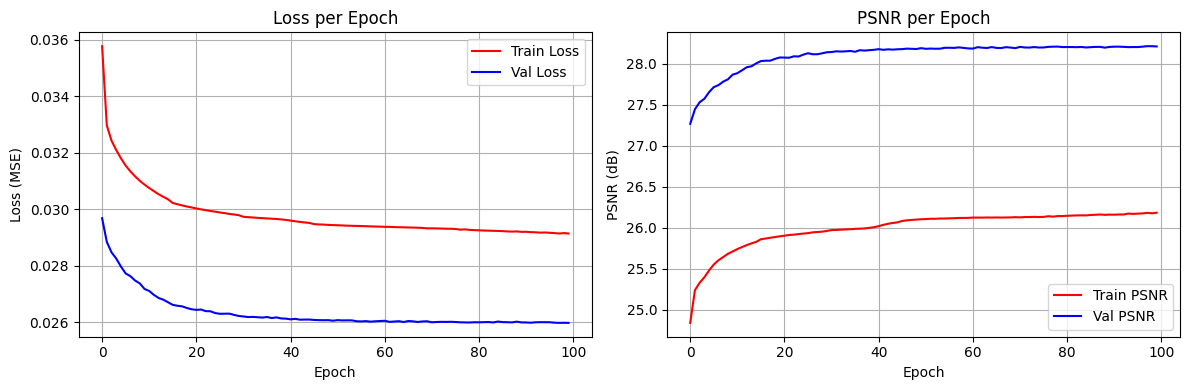

0

In [5]:
# config for finetuning
num_epochs=0
lr = 0.00000005
batch_size = 16
optimizer = optim.Adam(model_large.parameters(), lr=lr)

train_model_sr(
    model=model_large,
    model_name="custom_model_large_finetuned",
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    scale_factor=4,
    model_requires_upscale=False,
    best_model_path=best_model_path,
    last_model_path=last_model_path,
    mode="finetune",
    history_path=history_path,
    use_amp=True  
)
